<h2 align="center">Codebasics DL Course: Early Stopping<h2>

In [1]:
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data Loadings


Dataset Credits

@dataset{sonar-mines-vs-rocks,
  author = {Gorman, R Paul and Sejnowski, Terrence J.},
  title = {Connectionist Bench (Sonar, Mines vs. Rocks)},
  year = {1988},
  publisher = {University of California, Irvine. Machine Learning Repository},
  url = {https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks}
}

In [2]:
df = pd.read_csv("sonar.all-data", header=None)
df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
49,0.0119,0.0582,0.0623,0.0600,0.1397,0.1883,0.1422,0.1447,0.0487,0.0864,...,0.0025,0.0103,0.0074,0.0123,0.0069,0.0076,0.0073,0.0030,0.0138,R
104,0.0307,0.0523,0.0653,0.0521,0.0611,0.0577,0.0665,0.0664,0.1460,0.2792,...,0.0321,0.0189,0.0137,0.0277,0.0152,0.0052,0.0121,0.0124,0.0055,M
95,0.0291,0.0400,0.0771,0.0809,0.0521,0.1051,0.0145,0.0674,0.1294,0.1146,...,0.0056,0.0237,0.0204,0.0050,0.0137,0.0164,0.0081,0.0139,0.0111,R
145,0.0721,0.1574,0.1112,0.1085,0.0666,0.1800,0.1108,0.2794,0.1408,0.0795,...,0.0309,0.0127,0.0082,0.0281,0.0117,0.0092,0.0147,0.0157,0.0129,M
173,0.0329,0.0216,0.0386,0.0627,0.1158,0.1482,0.2054,0.1605,0.2532,0.2672,...,0.0095,0.0151,0.0059,0.0015,0.0053,0.0016,0.0042,0.0053,0.0074,M


In [3]:
df.shape

(208, 61)

In [4]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


In [5]:
df[60].value_counts()

60
M    111
R     97
Name: count, dtype: int64

In [6]:
df[60] = df[60].map({'M': 0, 'R': 1})
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,1
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,1
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,1


In [7]:
X = df.drop(60, axis=1)
y = df[60]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [8]:
X_train.shape

(156, 60)

In [9]:
y_train.values

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1])

In [10]:
# Convert the split arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [11]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Train a Neural Network

In [12]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(60, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Final output layer without activation for raw logits
        )

    def forward(self, x):
        return self.network(x)

In [13]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        y_pred, y_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(y_true, y_pred)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return train_losses, val_losses, val_accuracies

Epoch 1/20, Train Loss: 0.6894, Val Loss: 0.6647, Val Accuracy: 0.5192
Epoch 2/20, Train Loss: 0.6730, Val Loss: 0.6579, Val Accuracy: 0.5192
Epoch 3/20, Train Loss: 0.6618, Val Loss: 0.6357, Val Accuracy: 0.5192
Epoch 4/20, Train Loss: 0.6338, Val Loss: 0.6191, Val Accuracy: 0.7115
Epoch 5/20, Train Loss: 0.6015, Val Loss: 0.5934, Val Accuracy: 0.8077
Epoch 6/20, Train Loss: 0.5516, Val Loss: 0.5437, Val Accuracy: 0.6923
Epoch 7/20, Train Loss: 0.5001, Val Loss: 0.5515, Val Accuracy: 0.7500
Epoch 8/20, Train Loss: 0.4641, Val Loss: 0.4973, Val Accuracy: 0.7500
Epoch 9/20, Train Loss: 0.4254, Val Loss: 0.4920, Val Accuracy: 0.7500
Epoch 10/20, Train Loss: 0.3914, Val Loss: 0.5411, Val Accuracy: 0.7500
Epoch 11/20, Train Loss: 0.3778, Val Loss: 0.4851, Val Accuracy: 0.7692
Epoch 12/20, Train Loss: 0.3681, Val Loss: 0.5028, Val Accuracy: 0.7500
Epoch 13/20, Train Loss: 0.3657, Val Loss: 0.4833, Val Accuracy: 0.7308
Epoch 14/20, Train Loss: 0.3635, Val Loss: 0.5025, Val Accuracy: 0.7692
E

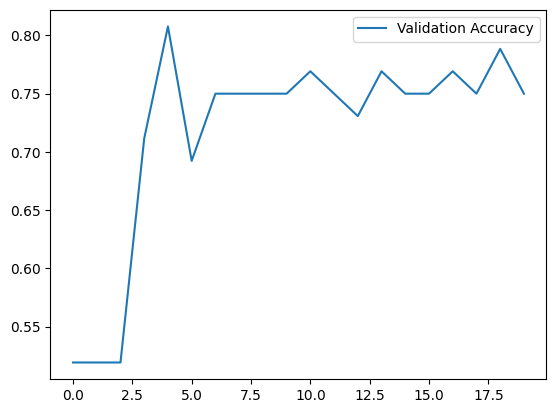

In [14]:
# Initialize and train the model without dropout
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, val_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, epochs=20
)

plt.plot(val_accuracies, label="Validation Accuracy")
plt.legend()
plt.show()

### Train a Neural Network With Early Stopping

In [15]:
# Training function
def train_model_early_stop(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    
    patience = 3
    best_accuracy = 0
    counter = 0
    
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        y_pred, y_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(y_true, y_pred)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early Stopping at Epoch {epoch+1}")
                break
    
    return train_losses, val_losses, val_accuracies

Epoch 1/20, Train Loss: 0.6841, Val Loss: 0.6564, Val Accuracy: 0.5192
Epoch 2/20, Train Loss: 0.6713, Val Loss: 0.6419, Val Accuracy: 0.5192
Epoch 3/20, Train Loss: 0.6491, Val Loss: 0.6197, Val Accuracy: 0.6538
Epoch 4/20, Train Loss: 0.6317, Val Loss: 0.6086, Val Accuracy: 0.7308
Epoch 5/20, Train Loss: 0.6011, Val Loss: 0.5611, Val Accuracy: 0.6538
Epoch 6/20, Train Loss: 0.5632, Val Loss: 0.5658, Val Accuracy: 0.8077
Epoch 7/20, Train Loss: 0.5251, Val Loss: 0.5133, Val Accuracy: 0.7500
Epoch 8/20, Train Loss: 0.4896, Val Loss: 0.5106, Val Accuracy: 0.7885
Epoch 9/20, Train Loss: 0.4504, Val Loss: 0.4861, Val Accuracy: 0.7500
Early Stopping at Epoch 9


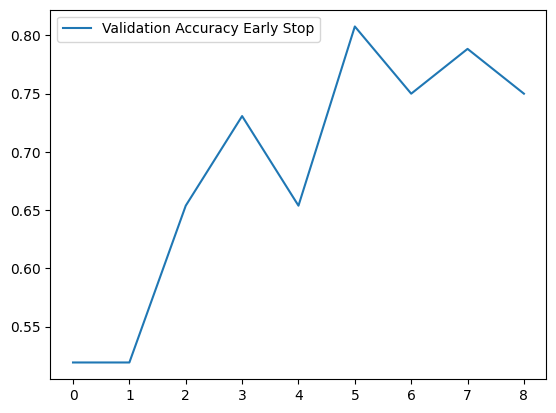

In [16]:
# Initialize and train the model without dropout
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, val_accuracies = train_model_early_stop(
    model, train_loader, test_loader, criterion, optimizer, epochs=20
)

plt.plot(val_accuracies, label="Validation Accuracy Early Stop")
plt.legend()
plt.show()

In [17]:
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [18]:
# Validation phase
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
val_accuracy = accuracy_score(y_true, y_pred)
val_accuracy

0.8076923076923077